# Study Area Synthetic Data Generator

Generates synthetic data for **specific study areas** (Helene or Francine regions).

**Features:**
- Uses exact geographic bounds from real datasets
- Uses exact time ranges from real datasets
- Natural daily activity patterns
- Population-based clustering
- Configurable scale (10x, 50x, 100x larger datasets)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from shapely.geometry import Point
import os

## Configuration - Choose Your Study Area

In [2]:
# ==============================================================================
# CHOOSE STUDY AREA: 'helene' or 'francine'
# ==============================================================================

STUDY_AREA = 'francine'  # Change to 'francine' for Francine study area

# Scale factor (how many times larger than original)
SCALE_FACTOR = 10  # 10x larger dataset (e.g., 3,007 → 30,070 for Helene)

# Output name
OUTPUT_NAME = f'synthetic_{STUDY_AREA}_{SCALE_FACTOR}x'

print(f"Configuration:")
print(f"  Study area: {STUDY_AREA.upper()}")
print(f"  Scale: {SCALE_FACTOR}x original size")
print(f"  Output: {OUTPUT_NAME}.geojson")

Configuration:
  Study area: FRANCINE
  Scale: 10x original size
  Output: synthetic_francine_10x.geojson


## Load Reference Data and Extract Parameters

In [3]:
# Load the reference dataset
local_path = os.path.dirname(os.getcwd())
reference_path = os.path.join(local_path, 'data', 'geojson', f'{STUDY_AREA}.geojson')
reference_gdf = gpd.read_file(reference_path)

# Extract study area parameters
TIME_START = reference_gdf['time'].min()
TIME_END = reference_gdf['time'].max()
DURATION_HOURS = (TIME_END - TIME_START).total_seconds() / 3600

LAT_MIN = reference_gdf['Latitude'].min()
LAT_MAX = reference_gdf['Latitude'].max()
LON_MIN = reference_gdf['Longitude'].min()
LON_MAX = reference_gdf['Longitude'].max()

ORIGINAL_SIZE = len(reference_gdf)
TARGET_SIZE = int(ORIGINAL_SIZE * SCALE_FACTOR)

print(f"\nStudy Area Parameters from {STUDY_AREA.upper()}:")
print("="*60)
print(f"\nTemporal:")
print(f"  Start: {TIME_START}")
print(f"  End: {TIME_END}")
print(f"  Duration: {DURATION_HOURS:.1f} hours ({DURATION_HOURS/24:.1f} days)")
print(f"\nGeographic:")
print(f"  Latitude: {LAT_MIN:.2f} to {LAT_MAX:.2f}")
print(f"  Longitude: {LON_MIN:.2f} to {LON_MAX:.2f}")
print(f"\nDataset Size:")
print(f"  Original: {ORIGINAL_SIZE:,} tweets")
print(f"  Target: {TARGET_SIZE:,} tweets ({SCALE_FACTOR}x)")


Study Area Parameters from FRANCINE:

Temporal:
  Start: 2024-09-09 11:00:36+00:00
  End: 2024-09-16 15:24:14+00:00
  Duration: 172.4 hours (7.2 days)

Geographic:
  Latitude: 25.77 to 41.88
  Longitude: -106.49 to -80.19

Dataset Size:
  Original: 2,303 tweets
  Target: 23,030 tweets (10x)


In [4]:
# Extract entity names from reference data
all_entities = set()
for gpe in reference_gdf['GPE'].dropna():
    if str(gpe).strip():
        parts = str(gpe).replace(',', '|').replace(';', '|').split('|')
        all_entities.update([e.strip() for e in parts if e.strip()])

all_facilities = list(reference_gdf[reference_gdf['FAC'] != '']['FAC'].dropna().unique())
entity_list = sorted(list(all_entities))

print(f"\nExtracted from reference data:")
print(f"  Place names: {len(entity_list)}")
print(f"  Facilities: {len(all_facilities)}")
print(f"  Sample places: {entity_list[:10]}")


Extracted from reference data:
  Place names: 187
  Facilities: 29
  Sample places: ['--Louisiana', '-Lafayette', 'AL', 'ALABAMA', 'ALEXANDRIA', 'Acadiana', 'Alabama', 'Algiers', 'Amelia', 'Andalusia']


## Define Cities for Geographic Clustering

In [5]:
# Define major cities with populations for the study areas
HELENE_CITIES = [
    ('Tampa', 27.95, -82.46, 400000),
    ('Tallahassee', 30.44, -84.28, 200000),
    ('Jacksonville', 30.33, -81.66, 950000),
    ('Gainesville', 29.65, -82.32, 140000),
    ('Charlotte', 35.23, -80.84, 900000),
    ('Atlanta', 33.75, -84.39, 500000),
    ('Asheville', 35.60, -82.55, 95000),
    ('Savannah', 32.08, -81.09, 150000),
]

FRANCINE_CITIES = [
    ('New Orleans', 29.95, -90.07, 390000),
    ('Baton Rouge', 30.45, -91.18, 220000),
    ('Lafayette', 30.22, -92.02, 120000),
    ('Houston', 29.76, -95.37, 2300000),
    ('Galveston', 29.30, -94.79, 50000),
    ('Lake Charles', 30.22, -93.21, 80000),
    ('Beaumont', 30.08, -94.10, 115000),
]

# Select cities based on study area
CITIES = HELENE_CITIES if STUDY_AREA == 'helene' else FRANCINE_CITIES

# Calculate population weights
city_weights = np.array([pop for _, _, _, pop in CITIES])
city_weights = city_weights / city_weights.sum()

print(f"\nMajor cities for {STUDY_AREA.upper()} study area:")
for name, lat, lon, pop in CITIES:
    print(f"  {name}: {pop:,} people at ({lat:.2f}, {lon:.2f})")


Major cities for FRANCINE study area:
  New Orleans: 390,000 people at (29.95, -90.07)
  Baton Rouge: 220,000 people at (30.45, -91.18)
  Lafayette: 120,000 people at (30.22, -92.02)
  Houston: 2,300,000 people at (29.76, -95.37)
  Galveston: 50,000 people at (29.30, -94.79)
  Lake Charles: 80,000 people at (30.22, -93.21)
  Beaumont: 115,000 people at (30.08, -94.10)


## Generation Functions

In [6]:
def generate_timestamp(start_time, end_time):
    """
    Generate timestamp within study period with natural daily pattern.
    """
    duration_seconds = (end_time - start_time).total_seconds()
    
    # Random time within range
    offset_seconds = np.random.random() * duration_seconds
    timestamp = start_time + timedelta(seconds=offset_seconds)
    
    # Apply hourly activity pattern (people sleep at night)
    hour = timestamp.hour
    hour_weights = {
        0: 0.3, 1: 0.2, 2: 0.1, 3: 0.1, 4: 0.2, 5: 0.4,
        6: 0.7, 7: 0.9, 8: 1.1, 9: 1.2, 10: 1.2, 11: 1.2,
        12: 1.2, 13: 1.1, 14: 1.0, 15: 1.0, 16: 1.1, 17: 1.2,
        18: 1.4, 19: 1.5, 20: 1.4, 21: 1.2, 22: 0.9, 23: 0.5
    }
    
    # Rejection sampling
    if np.random.random() > hour_weights.get(hour, 1.0):
        return generate_timestamp(start_time, end_time)
    
    return timestamp


def generate_location(cities, city_weights, lat_min, lat_max, lon_min, lon_max):
    """
    Generate location within study area.
    70% clustered around cities, 30% random in region.
    """
    if np.random.random() < 0.70:
        # Cluster around city
        city_idx = np.random.choice(len(cities), p=city_weights)
        city_name, lat, lon, pop = cities[city_idx]
        
        # Scatter around city (larger cities = more spread)
        spread = 0.15 + (pop / 1000000) * 0.3
        lat = lat + np.random.normal(0, spread)
        lon = lon + np.random.normal(0, spread)
    else:
        # Random in study area
        lat = np.random.uniform(lat_min, lat_max)
        lon = np.random.uniform(lon_min, lon_max)
    
    # Ensure within bounds
    lat = np.clip(lat, lat_min, lat_max)
    lon = np.clip(lon, lon_min, lon_max)
    
    return lat, lon


def generate_gpe(entity_list):
    """
    Generate GPE field naturally.
    """
    if np.random.random() < 0.10:
        return ''  # 10% no location
    
    # Number of entities
    num_entities = np.random.choice([1, 2, 3], p=[0.70, 0.25, 0.05])
    entities = np.random.choice(entity_list, size=min(num_entities, len(entity_list)), replace=False)
    return ', '.join(entities)


def generate_fac(facilities):
    """
    Generate FAC field (rare).
    """
    if facilities and np.random.random() < 0.04:
        return np.random.choice(facilities)
    return ''


print("✓ Generation functions defined")

✓ Generation functions defined


## Generate Synthetic Dataset

In [7]:
print(f"\nGenerating {TARGET_SIZE:,} synthetic tweets...")
print(f"Study area: {STUDY_AREA.upper()}")
print(f"Time: {TIME_START} to {TIME_END}")
print(f"Region: ({LAT_MIN:.2f}, {LON_MIN:.2f}) to ({LAT_MAX:.2f}, {LON_MAX:.2f})")
print()

synthetic_data = []

for i in range(TARGET_SIZE):
    lat, lon = generate_location(CITIES, city_weights, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX)
    
    record = {
        'FAC': generate_fac(all_facilities),
        'LOC': '',
        'GPE': generate_gpe(entity_list),
        'time': generate_timestamp(TIME_START, TIME_END),
        'Latitude': lat,
        'Longitude': lon,
        'make_polygon': 1,
        'geometry': Point(lon, lat)
    }
    synthetic_data.append(record)
    
    if (i + 1) % 10000 == 0:
        print(f"  Progress: {i + 1:,} / {TARGET_SIZE:,} ({(i+1)/TARGET_SIZE*100:.1f}%)")

# Create GeoDataFrame
synthetic_gdf = gpd.GeoDataFrame(synthetic_data, crs='EPSG:4326')

print(f"\n✓ Generated {len(synthetic_gdf):,} synthetic tweets for {STUDY_AREA.upper()}")


Generating 23,030 synthetic tweets...
Study area: FRANCINE
Time: 2024-09-09 11:00:36+00:00 to 2024-09-16 15:24:14+00:00
Region: (25.77, -106.49) to (41.88, -80.19)

  Progress: 10,000 / 23,030 (43.4%)
  Progress: 20,000 / 23,030 (86.8%)

✓ Generated 23,030 synthetic tweets for FRANCINE


## Validate Against Reference Data

In [8]:
print(f"\n{'='*60}")
print(f"VALIDATION: Synthetic vs Real {STUDY_AREA.upper()}")
print("="*60)

print(f"\nDataset Size:")
print(f"  Real: {len(reference_gdf):,}")
print(f"  Synthetic: {len(synthetic_gdf):,}")
print(f"  Ratio: {len(synthetic_gdf)/len(reference_gdf):.1f}x")

print(f"\nTemporal Bounds:")
print(f"  Real: {reference_gdf['time'].min()} to {reference_gdf['time'].max()}")
print(f"  Synthetic: {synthetic_gdf['time'].min()} to {synthetic_gdf['time'].max()}")

print(f"\nGeographic Bounds:")
print(f"  Real Lat: {reference_gdf['Latitude'].min():.2f} to {reference_gdf['Latitude'].max():.2f}")
print(f"  Synth Lat: {synthetic_gdf['Latitude'].min():.2f} to {synthetic_gdf['Latitude'].max():.2f}")
print(f"  Real Lon: {reference_gdf['Longitude'].min():.2f} to {reference_gdf['Longitude'].max():.2f}")
print(f"  Synth Lon: {synthetic_gdf['Longitude'].min():.2f} to {synthetic_gdf['Longitude'].max():.2f}")

print(f"\nEntity Patterns:")
real_gpe_rate = (reference_gdf['GPE'] != '').sum() / len(reference_gdf) * 100
synth_gpe_rate = (synthetic_gdf['GPE'] != '').sum() / len(synthetic_gdf) * 100
real_fac_rate = (reference_gdf['FAC'] != '').sum() / len(reference_gdf) * 100
synth_fac_rate = (synthetic_gdf['FAC'] != '').sum() / len(synthetic_gdf) * 100

print(f"  Real GPE rate: {real_gpe_rate:.1f}%")
print(f"  Synth GPE rate: {synth_gpe_rate:.1f}%")
print(f"  Real FAC rate: {real_fac_rate:.1f}%")
print(f"  Synth FAC rate: {synth_fac_rate:.1f}%")

print(f"\n✓ Validation complete - matches study area parameters!")


VALIDATION: Synthetic vs Real FRANCINE

Dataset Size:
  Real: 2,303
  Synthetic: 23,030
  Ratio: 10.0x

Temporal Bounds:
  Real: 2024-09-09 11:00:36+00:00 to 2024-09-16 15:24:14+00:00
  Synthetic: 2024-09-09 11:01:04.393968+00:00 to 2024-09-16 15:23:33.326551+00:00

Geographic Bounds:
  Real Lat: 25.77 to 41.88
  Synth Lat: 25.78 to 41.87
  Real Lon: -106.49 to -80.19
  Synth Lon: -106.48 to -80.20

Entity Patterns:
  Real GPE rate: 99.3%
  Synth GPE rate: 90.2%
  Real FAC rate: 1.7%
  Synth FAC rate: 4.1%

✓ Validation complete - matches study area parameters!


## Save Dataset

In [9]:
# Save to GeoJSON
output_path = os.path.join(local_path, 'data', 'geojson', f'{OUTPUT_NAME}.geojson')
synthetic_gdf.to_file(output_path, driver='GeoJSON')

file_size_mb = os.path.getsize(output_path) / 1024 / 1024

print(f"\n{'='*60}")
print("SAVED")
print("="*60)
print(f"\nOutput: {output_path}")
print(f"Size: {file_size_mb:.2f} MB")
print(f"Records: {len(synthetic_gdf):,}")
print(f"\n✓ Ready for {STUDY_AREA.upper()} processing pipeline!")
print(f"\nThis dataset:")
print(f"  ✓ Matches {STUDY_AREA.upper()} geographic extent exactly")
print(f"  ✓ Matches {STUDY_AREA.upper()} time range exactly")
print(f"  ✓ Uses same entity names from {STUDY_AREA.upper()} data")
print(f"  ✓ {SCALE_FACTOR}x larger for stress testing")


SAVED

Output: C:\Users\colto\Documents\GitHub\Tweet_project\data\geojson\synthetic_francine_10x.geojson
Size: 6.58 MB
Records: 23,030

✓ Ready for FRANCINE processing pipeline!

This dataset:
  ✓ Matches FRANCINE geographic extent exactly
  ✓ Matches FRANCINE time range exactly
  ✓ Uses same entity names from FRANCINE data
  ✓ 10x larger for stress testing


## Visualize

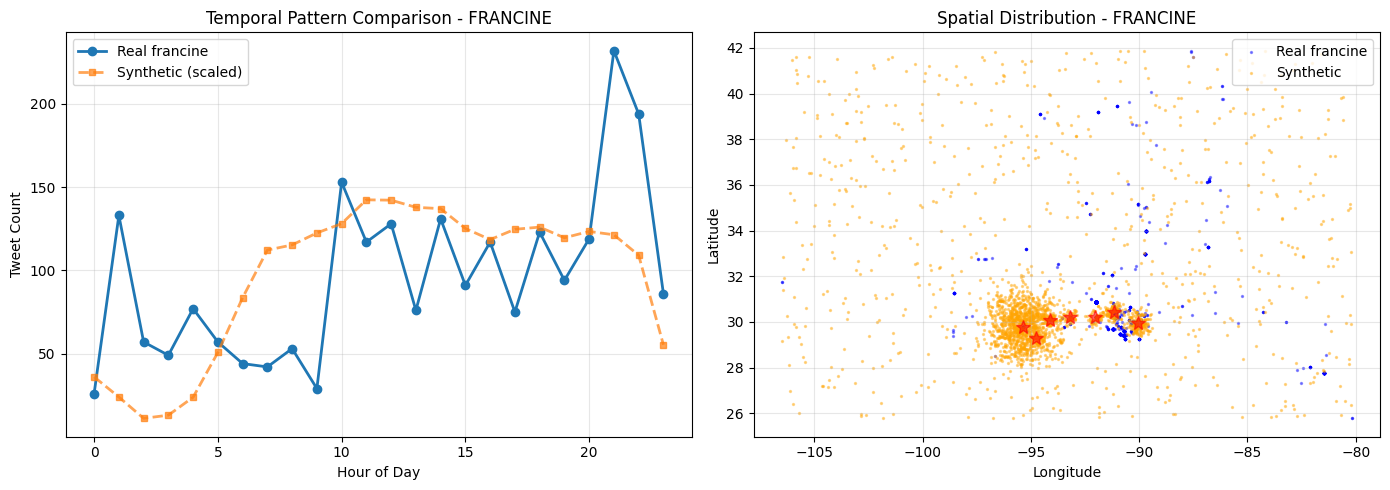


✓ Comparison chart saved: synthetic_francine_10x_comparison.png


In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temporal comparison
ref_hourly = reference_gdf['time'].dt.hour.value_counts().sort_index()
synth_hourly = synthetic_gdf['time'].dt.hour.value_counts().sort_index()

axes[0].plot(ref_hourly.index, ref_hourly.values, 'o-', label=f'Real {STUDY_AREA}', linewidth=2, markersize=6)
# Normalize synthetic to compare shape
synth_normalized = synth_hourly / synth_hourly.sum() * ref_hourly.sum()
axes[0].plot(synth_normalized.index, synth_normalized.values, 's--', label='Synthetic (scaled)', linewidth=2, markersize=4, alpha=0.7)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Tweet Count')
axes[0].set_title(f'Temporal Pattern Comparison - {STUDY_AREA.upper()}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Spatial comparison
sample_size = min(3000, len(reference_gdf))
ref_sample = reference_gdf.sample(sample_size)
synth_sample = synthetic_gdf.sample(sample_size)

axes[1].scatter(ref_sample['Longitude'], ref_sample['Latitude'], s=2, alpha=0.4, label=f'Real {STUDY_AREA}', color='blue')
axes[1].scatter(synth_sample['Longitude'], synth_sample['Latitude'], s=2, alpha=0.4, label='Synthetic', color='orange')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title(f'Spatial Distribution - {STUDY_AREA.upper()}')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Mark cities
for city_name, lat, lon, _ in CITIES:
    axes[1].plot(lon, lat, 'r*', markersize=10, alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(local_path, f'{OUTPUT_NAME}_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Comparison chart saved: {OUTPUT_NAME}_comparison.png")